In [270]:
import pandas as pd 
import numpy as np 
from pandas.api.types import CategoricalDtype

import matplotlib.pyplot as plt

import seaborn as sns
from sklearn import linear_model as lm

import warnings
warnings.filterwarnings("ignore")

import zipfile
import os
os.chdir('/Users/samue/Documents/Brown/Personal Projects/cook-county')
''' 
1. How does index_col="Unnamed: 0" work
2. How does the distribution plotting work
3. How does filtering out Description work
4. What is overplotting
5. OHE vs vectorizing

Issues:
1. Plots were overplotting the data --> restrict my search
2. Values were too extreme for things like sale price and sqfootage; had to consider log
3. After completing the actual regression, I noticed that neighborhood code didn't actually play a big role, which contradicts what I would think logically
    Thus, I decided to pursue a decision tree modeling for this as well.
'''

' \n1. How does index_col="Unnamed: 0" work\n2. How does the distribution plotting work\n3. How does filtering out Description work\n4. What is overplotting\n5. OHE vs vectorizing\n\nIssues:\n1. Plots were overplotting the data --> restrict my search\n2. Values were too extreme for things like sale price and sqfootage; had to consider log\n3. After completing the actual regression, I noticed that neighborhood code didn\'t actually play a big role, which contradicts what I would think logically\n    Thus, I decided to pursue a decision tree modeling for this as well.\n'

# Exploratory Data Analysis (EDA)

## Context

We seek to examine the housing records dataset from Cook County, a cluster of neighborhoods in Chicago. In Cook County, the county assessor's office (AO)determines valuations for homes for property taxes. When done fairly, these assessments are an equitable and transparent way to determine property tax bills. However, the Cook County AO had consistently overestimated the housing prices of the lower income, working class and underestimated that of the upper class - this perpetuates a system of inequality.

Indeed, property taxes are a zero-sum game: when the rich pay less, then the poor pay more.

Appeals are given as an option for homeowners with overvalued properties, yet this process makes an already unequal system even less fair. Owners of high-priced homes are far more likely to appeal compared to owners of low-valued homes. This meant that the rich consistently appealed their housing appraisals, driving down their property taxes, whereas the poor had consistently over-valued homes without the ability to appeal.

Read more here: https://apps.chicagotribune.com/news/watchdog/cook-county-property-tax-divide/assessments.html

### The Data

In [271]:
with zipfile.ZipFile("cook_county_data.zip") as item:
    item.extractall()

In [272]:
training_data = pd.read_csv(filepath_or_buffer="cook_county_train.csv", index_col="Unnamed: 0")
training_data.shape

(204792, 62)

In [273]:
training_data.columns.values

array(['PIN', 'Property Class', 'Neighborhood Code', 'Land Square Feet',
       'Town Code', 'Apartments', 'Wall Material', 'Roof Material',
       'Basement', 'Basement Finish', 'Central Heating', 'Other Heating',
       'Central Air', 'Fireplaces', 'Attic Type', 'Attic Finish',
       'Design Plan', 'Cathedral Ceiling', 'Construction Quality',
       'Site Desirability', 'Garage 1 Size', 'Garage 1 Material',
       'Garage 1 Attachment', 'Garage 1 Area', 'Garage 2 Size',
       'Garage 2 Material', 'Garage 2 Attachment', 'Garage 2 Area',
       'Porch', 'Other Improvements', 'Building Square Feet',
       'Repair Condition', 'Multi Code', 'Number of Commercial Units',
       'Estimate (Land)', 'Estimate (Building)', 'Deed No.', 'Sale Price',
       'Longitude', 'Latitude', 'Census Tract',
       'Multi Property Indicator', 'Modeling Group', 'Age', 'Use',
       "O'Hare Noise", 'Floodplain', 'Road Proximity', 'Sale Year',
       'Sale Quarter', 'Sale Half-Year', 'Sale Quarter of Year'

We note that there are indeed 204792 data points and 62 features. Notably, along with sale price, we are given:

    1. Neighborhood Code

    2. Land Square Feet

    3. Town Code

    4. Roof Material

    5. Building Square Feet

    6. Age

    7. Most Recent Sale
    
    8. Description

## Basic Data Visualization

In [274]:
def visualize_distribution(data, feature):
    '''
    Function that plots the distribution of a dataset
    Parameters:
        data -- dataset; DataFrame
        feature -- variable to plot; str
    Return:
        None
    '''
    # nrows=2 because we are only plotting boxplot and histogram
    fig, axs = plt.subplots(nrows=2)

    sns.boxplot(
        data=data[feature],
        ax=axs[0]
    )

    sns.histplot(
        data=data[feature],
        ax=axs[1],
        kde=True
    )

    plt.tight_layout()
    plt.show()

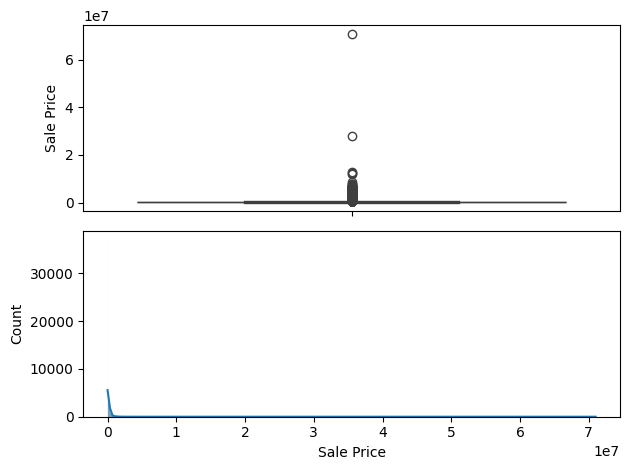

In [275]:
visualize_distribution(data=training_data, feature="Sale Price")

The graphs are uninterpretable; the values of Sale Price are too large / extreme outliers exist (e.g. very expensive homes). To confirm, we examine the maximum sale price.

In [276]:
np.max(training_data["Sale Price"]), np.min(training_data["Sale Price"]), np.median(training_data["Sale Price"]), np.mean(training_data["Sale Price"]), np.std(training_data["Sale Price"])

(np.int64(71000000),
 np.int64(1),
 np.float64(175000.0),
 np.float64(245164.62106918238),
 np.float64(362868.5140283661))

## Log Sale Price

The maximum value is 71,000,000 USD, contributing to a large standard deviation of 362,868.51 USD as the mean is 245,164.62 USD and median is 175,000 USD. This aligns with the boxplot and histogram - the histogram is severely right skewed for sale price. 

We thus want to consider the log sale price to improve the visualization of the sale price's distribution, as extreme values will be less pronounced. Further note that the minimum value is 1 USD - we ought to filter out nonsense values as well (reasonably defined as values less than 10,000 USD).

In [277]:
training_data = training_data[training_data["Sale Price"] >= 10000]
training_data["Log Sale Price"] = np.log(training_data["Sale Price"])

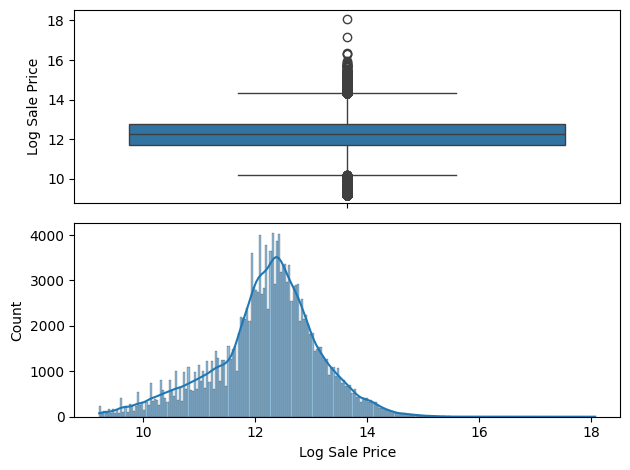

In [278]:
visualize_distribution(data=training_data, feature="Log Sale Price")

The resulting box plot and histogram are much more interpretable; specifically, we observe the following:

    - The histogram distribution is symmetric and unimodal, but slightly right skewed (still observe expensive house outliers)
    
    - The median log sale price is around 12.5

    - The interquartile range is quite narrow, meaning most log sale prices fall within the narrow range from 12 to 13

Let's also make the filtering more robust.

In [279]:
def filter_data(data, feature, lower=float('-inf'), upper=float('inf')):
    ''' 
    Function that filters a dataset restricted to an upper and lower bound.
    Note: does NOT modify data itself
    Parameters:
        data -- dataset to filter; DataFrame
        feature -- feature with numerical data to filter; str
        lower -- lower bound; int
        upper -- upper bound; int
    Return:
        Copy of data, filtered
    '''
    return data[(data[feature] >= lower) & (data[feature] <= upper)]


## Square Footage

One feature that may reasonably predict sale price is building square footage. However, note that we ought to consider the log square footage for the same reasoning that we choose to consider the log sale price. 

In [280]:
training_data["Log Building Square Feet"] = np.log(training_data["Building Square Feet"])

Let's fit a simple bivariate regression model using log building square footage to predict log sale price.

In [281]:
training_data["Log Building Square Feet"].shape, training_data["Log Sale Price"].shape


training_data["Log Building Square Feet"].to_numpy().reshape(-1,1).shape

(167610, 1)

In [282]:
model = lm.LinearRegression()
model.fit(X=training_data["Log Building Square Feet"].to_numpy().reshape(-1,1), y=training_data["Log Sale Price"].to_numpy())

model.intercept_, model.coef_

(np.float64(2.508079486636664), array([1.32824374]))

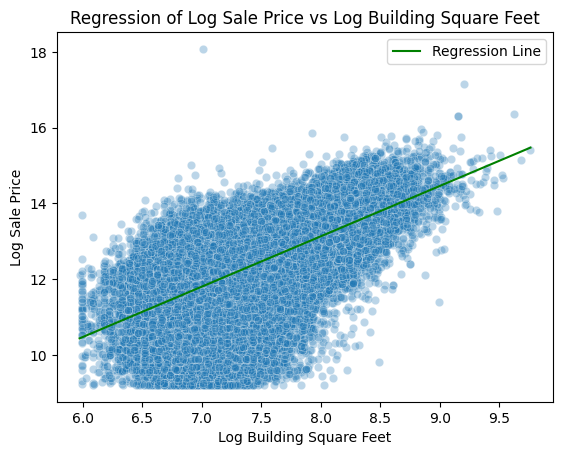

In [283]:
sns.scatterplot(
    x=training_data["Log Building Square Feet"],
    y=training_data["Log Sale Price"],
    alpha=0.3,
)

x_vals = np.linspace(training_data["Log Building Square Feet"].min(),
                     training_data["Log Building Square Feet"].max(),
                     100)
y_vals = model.intercept_ + model.coef_[0] * x_vals

plt.plot(x_vals, y_vals, color="green", label="Regression Line")

plt.xlabel("Log Building Square Feet")
plt.ylabel("Log Sale Price")
plt.title("Regression of Log Sale Price vs Log Building Square Feet")
plt.legend()
plt.show()

There exists a clear positive relationship between log building square feet and log sale price - as seen in the scatterplot and its corresponding regression line, larger values of log building square feet correlate with larger values of log sale price. This means that log building square feet may be an optimal feature to estimate log sale price.

## Basic Feature Engineering

The "Description" feature reveals attributes of the home that may be informative for predicting sale price.

In [284]:
training_data["Description"][1]

'This property, sold on 05/23/2018, is a one-story houeshold located at 2844 N LOWELL AVE.It has a total of 6 rooms, 3 of which are bedrooms, and 1.0 of which are bathrooms.'

In [285]:
training_data["Description"][2]

'This property, sold on 02/18/2016, is a one-story houeshold located at 11415 S PRAIRIE AVE.It has a total of 7 rooms, 3 of which are bedrooms, and 1.0 of which are bathrooms.'

The formatting of the description is consistent, and it tells us the following information:

    - Date of sale

    - Number of stories

    - Address

    - Number of rooms

    - Number of bedrooms

    - Number of bathrooms

Of these attributes, the number of stories, bedrooms, and bathrooms are of interest. We can leverage the consistent formatting of the description feature to filter out the relevant numerical information from the categorial descriptor.

In [286]:
def add_number_stories(data):
    ''' 
    Function that adds a feature consisting of the number of stories, extracted from the description feature.
    Note: does NOT modify data itself
    Parameters:
        data -- data to extract from; DataFrame
    Return:
        Copy of data with the added column for number of stories
    '''
    word_to_number = {
        "zero": 0, "one": 1, "two": 2, "three": 3, "four": 4, "five": 5, "six": 6
    }

    stories = data.copy()
    stories["Stories"] = stories["Description"].str.extract(r'(zero|one|two|three|four|five|six)-story')
    stories["Stories"] = stories["Stories"].fillna("zero")
    stories["Stories"] = stories["Stories"].str.lower().replace(word_to_number)
    stories["Stories"] = stories["Stories"].astype(int)
    return stories

def add_number_bedrooms(data):
    ''' 
    Function that adds a feature consisting of the number of bedrooms, extracted from the description feature.
    Note: does NOT modify data itself
    Parameters:
        data -- data to extract from; DataFrame
    Return:
        Copy of data with the added column for number of bedrooms
    '''
    bedrooms = data.copy()
    bedrooms["Bedrooms"] = bedrooms["Description"].str.extract(r'(\d+) of which are bedrooms')
    bedrooms["Bedrooms"] = bedrooms["Bedrooms"].fillna('0')
    bedrooms["Bedrooms"] = bedrooms["Bedrooms"].astype(int)
    return bedrooms

def add_number_bathrooms(data):
    ''' 
    Function that adds a feature consisting of the number of bathrooms, extracted from the description feature.
    Note: does NOT modify data itself
    Parameters:
        data -- data to extract from; DataFrame
    Return:
        Copy of data with the added column for number of bathrooms
    '''
    bathrooms = data.copy()
    bathrooms["Bathrooms"] = bathrooms["Description"].str.extract(r'(\d+\.?\d*) of which are bathrooms')
    bathrooms["Bathrooms"] = bathrooms["Bathrooms"].fillna('0')
    bathrooms["Bathrooms"] = bathrooms["Bathrooms"].astype(float)
    return bathrooms


In [287]:
training_data = add_number_stories(training_data)
training_data = add_number_bedrooms(training_data)
training_data = add_number_bathrooms(training_data)

Now let's test a few plots to visualize the relationship between the number of bedrooms (and stories and bathrooms) and sale price. Ideally, we want our model to avoid overplotting and clearly demonstrate the strength of the correlation between our two variables.

### Violin Plots

In [288]:
def visualize_violin_plot(input, feature):
    ''' 
    Function that visualizes a violin plot for a specified feature
    Parameters:
        input -- data to visualize; DataFrame
        feature -- independent variable; str
    Return:
        None
    '''
    sns.violinplot(
        data = input,
        x= feature,
        y= "Log Sale Price"
    ).set(title=f"Log Sale Price vs Number of {feature}", xlabel = f"Number of {feature}")

    plt.show()

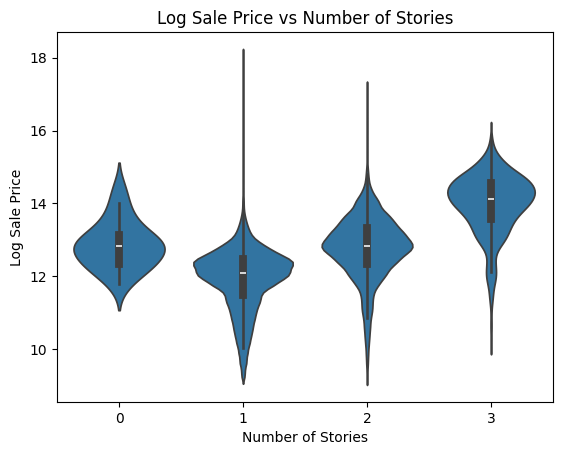

In [289]:
visualize_violin_plot(training_data, "Stories")

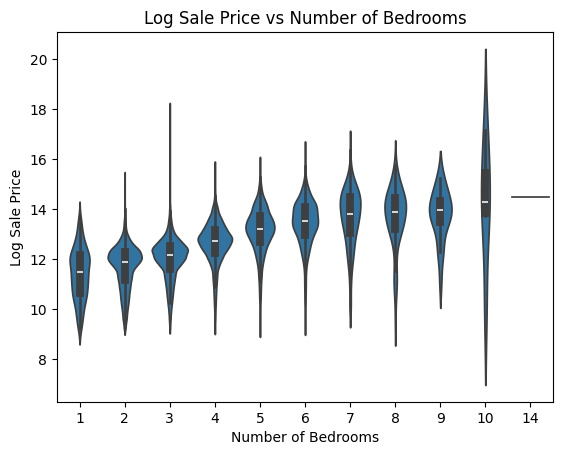

In [290]:
visualize_violin_plot(training_data, "Bedrooms")

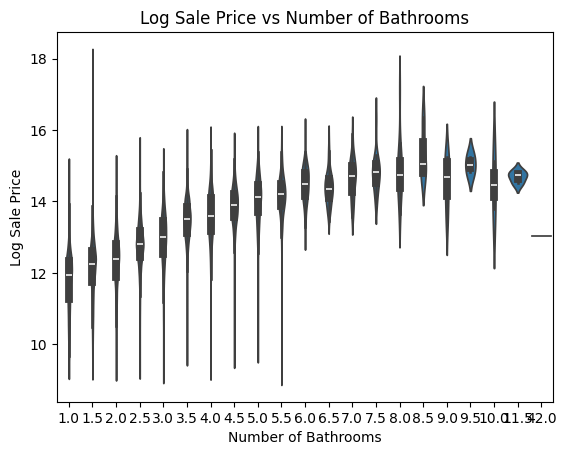

In [291]:
visualize_violin_plot(training_data, "Bathrooms")

There are some extreme outliers for bathrooms that impair the intrepretability of the Log Sale Price vs Number of Bathrooms violin plot. There are a few homes with 11.5 bathrooms and one with 42 bathrooms, so we will remove all bathrooms greater than 12. Let's filter and revisualize.

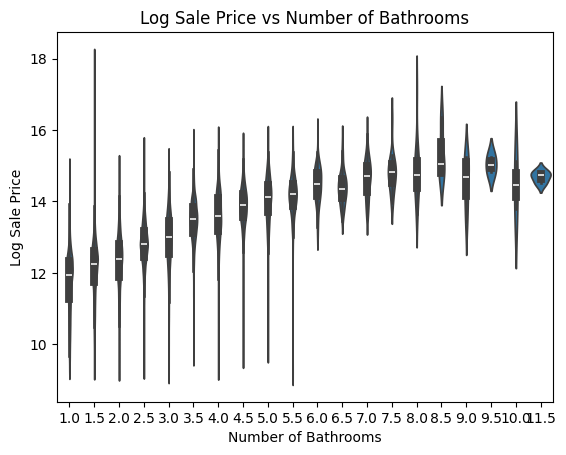

In [292]:
training_data = filter_data(training_data, "Bathrooms", upper=12)

visualize_violin_plot(training_data, "Bathrooms")

## One Hot Encoding

So far we have only worked with numerical variables, but we ought to consider some categorical variables as well. Upon further research, roof material may actually be a strong predictor for the sale price of homes, especially in Cook County. 

### Roof Material

Especially in the extreme climate of Chicago, roof material can influence housing prices due to factores like energy efficiency (tile and slate offer better insulation, which can lower heating costs during cold Chicago winters), durability (slate and tile are more durable and can last longer than asphalt or shake), maintenance costs (shake may require more frequent maintenance, whereas asphalt may need to be replaced more often), and aesthetic appeal (slate and tile may appeal to luxury buyers and thus increase property value, whereas basic materials such as shingle and asphalt are more common in less expensive homes).

In this dataset, the integer in the "Roof Material" feature maps to a specific material, as given by the following mappings:

    1. Shingle/Asphalt

    2. Tar&Gravel

    3. Slate

    4. Shake

    5. Tile
    
    6. Other

We note that it is NOT sufficient nor accurate to treat this integer as a numerical feature, as it is actually just a representation for a specific categorical feature, and results treating it as numerical would be both incorrect and misleading.

Let's one-hot-encode / vectorize this categorical feature.

In [293]:
training_data["Roof Material"][200100]

np.float64(4.0)

In [294]:
training_data["Roof Material"][1]

np.float64(1.0)

In [295]:
def restructure_roof_material(data):
    ''' 
    Function that restructures the roof material from int to str
    Note: original data is not modified
    Parameters:
        data -- data to restructure; DataFrame
    Return:
        DataFrame identical to the input data, but with Roof Material restructured
    '''
    mapping = {1: "Shingle/Asphalt", 2: "Tar&Gravel", 3: "Slate", 4: "Shake", 5: "Tile", 6: "Other"}
    return data.replace({"Roof Material": mapping})

training_data = restructure_roof_material(training_data)
training_data.head()

,PIN,Property Class,Neighborhood Code,Land Square Feet,Town Code,Apartments,Wall Material,Roof Material,Basement,Basement Finish,...,Garage Indicator,Neigborhood Code (mapping),Town and Neighborhood,Description,Lot Size,Log Sale Price,Log Building Square Feet,Stories,Bedrooms,Bathrooms
1,13272240180000,202,120,3780.0,71,0.0,2.0,Shingle/Asphalt,1.0,1.0,...,1.0,120,71120,"This property, sold on 05/23/2018, is a one-st...",3780.0,12.560244,6.904751,1,3,1.0
2,25221150230000,202,210,4375.0,70,0.0,2.0,Shingle/Asphalt,2.0,3.0,...,1.0,210,70210,"This property, sold on 02/18/2016, is a one-st...",4375.0,9.998798,6.810142,1,3,1.0
3,10251130030000,203,220,4375.0,17,0.0,3.0,Shingle/Asphalt,1.0,3.0,...,1.0,220,17220,"This property, sold on 07/23/2013, is a one-st...",4375.0,12.323856,7.068172,1,3,1.5
4,31361040550000,202,120,8400.0,32,0.0,3.0,Shingle/Asphalt,2.0,3.0,...,1.0,120,32120,"This property, sold on 06/10/2016, is a one-st...",8400.0,10.025705,6.855409,1,2,1.0
6,30314240080000,203,181,10890.0,37,0.0,1.0,Shingle/Asphalt,1.0,3.0,...,1.0,181,37181,"This property, sold on 10/26/2017, is a one-st...",10890.0,11.512925,7.458186,1,4,1.5


In [296]:
from sklearn.preprocessing import OneHotEncoder

def ohe_roof_material(data):
    ''' 
    Function that one-hot-encodes the roof material of the given dataset
    Note: does not modify the original data
    Parameters:
        data -- data to ohe; DataFrame
    Return:
        new DataFrame one-hot-encoded in the form Roof Material_X where X is a material
    '''
    ohe = OneHotEncoder(sparse_output=False)
    encoded_data = ohe.fit_transform(data[["Roof Material"]]) # ohe requires 2d input
    feature_names = ohe.get_feature_names_out()
    encoded_df = pd.DataFrame(data=encoded_data, columns=feature_names, index=data.index)
    return data.drop(columns="Roof Material").join(encoded_df)

ohe_roof_material(training_data)

,PIN,Property Class,Neighborhood Code,Land Square Feet,Town Code,Apartments,Wall Material,Basement,Basement Finish,Central Heating,...,Log Building Square Feet,Stories,Bedrooms,Bathrooms,Roof Material_Other,Roof Material_Shake,Roof Material_Shingle/Asphalt,Roof Material_Slate,Roof Material_Tar&Gravel,Roof Material_Tile
1,13272240180000,202,120,3780.0,71,0.0,2.0,1.0,1.0,2.0,...,6.904751,1,3,1.0,0.0,0.0,1.0,0.0,0.0,0.0
2,25221150230000,202,210,4375.0,70,0.0,2.0,2.0,3.0,1.0,...,6.810142,1,3,1.0,0.0,0.0,1.0,0.0,0.0,0.0
3,10251130030000,203,220,4375.0,17,0.0,3.0,1.0,3.0,1.0,...,7.068172,1,3,1.5,0.0,0.0,1.0,0.0,0.0,0.0
4,31361040550000,202,120,8400.0,32,0.0,3.0,2.0,3.0,2.0,...,6.855409,1,2,1.0,0.0,0.0,1.0,0.0,0.0,0.0
6,30314240080000,203,181,10890.0,37,0.0,1.0,1.0,3.0,1.0,...,7.458186,1,4,1.5,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204787,25163010260000,202,321,4375.0,72,0.0,2.0,1.0,1.0,1.0,...,6.813445,1,2,1.0,0.0,0.0,1.0,0.0,0.0,0.0
204788,5063010090000,204,21,16509.0,23,0.0,1.0,1.0,1.0,1.0,...,7.603399,1,4,1.5,0.0,0.0,1.0,0.0,0.0,0.0
204789,16333020150000,202,90,3810.0,15,0.0,2.0,1.0,1.0,1.0,...,6.815640,1,3,2.0,0.0,0.0,1.0,0.0,0.0,0.0
204790,9242030500000,203,80,6650.0,22,0.0,2.0,1.0,3.0,1.0,...,7.092574,1,3,1.0,0.0,0.0,1.0,0.0,0.0,0.0


## Neighborhood Codes

Now let's consider an interesting question: does neighborhood code have a significant impact on sale price of homes?

In [297]:
num_neighborhoods = len(training_data['Neighborhood Code'].unique())
num_neighborhoods

193

Let's understand what a plot of neighborhood codes and sale prices would look like.

In [298]:
def plot_categorical_feature(subset, dependent, independent):
    ''' 
    Function that plots a boxplot and countplot for a categorical feature
    Parameters:
        subset -- subset to plot; DataFrame
        dependent -- dependent variable; str
        independent -- independent variable; str 
    Returns:
        None
    '''
    fig, axs = plt.subplots(nrows=2)

    sns.boxplot(
        x = independent,
        y = dependent,
        data=subset,
        ax=axs[0]
    )
    sns.countplot(
        x = independent,
        data=subset,
        ax=axs[1],
    )

    plt.tight_layout()
    plt.show()

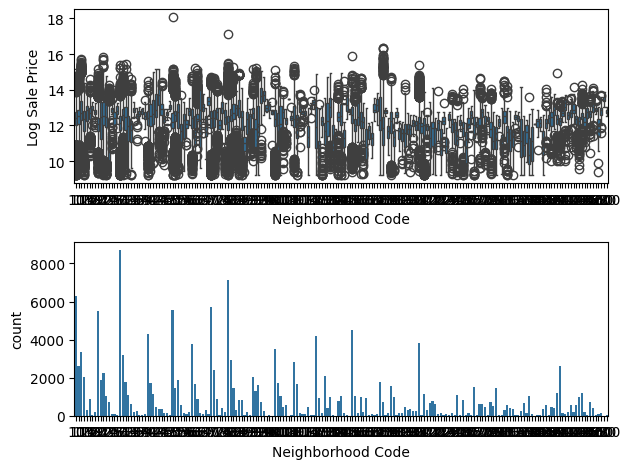

In [299]:
plot_categorical_feature(training_data, "Log Sale Price", "Neighborhood Code")

There are far too many neighborhood codes for the visualization to actually be useful. We note that there are many neighborhoods with very few homes - these are not as informative for predicting sale price as the neighborhoods with many homes.

Thus, to improve interpretability, we ought to filter out the neighborhoods with the most homes.

In [300]:
def filter_neighborhoods(data, X):
    ''' 
    Function that filters out the top X neighborhoods in terms of number of homes
    Parameters:
        data -- data to filter from; DataFrame
        X -- upper bound; int
    Returns:
        DataFrame, filtered
    '''
    top_X_neighborhoods = data["Neighborhood Code"].value_counts()[0:X].index
    filtered_data = data[data["Neighborhood Code"].isin(top_X_neighborhoods)]
    return filtered_data

In [301]:
top_10_neighborhoods = filter_neighborhoods(training_data, 10)
top_10_neighborhoods.head()

,PIN,Property Class,Neighborhood Code,Land Square Feet,Town Code,Apartments,Wall Material,Roof Material,Basement,Basement Finish,...,Garage Indicator,Neigborhood Code (mapping),Town and Neighborhood,Description,Lot Size,Log Sale Price,Log Building Square Feet,Stories,Bedrooms,Bathrooms
1,13272240180000,202,120,3780.0,71,0.0,2.0,Shingle/Asphalt,1.0,1.0,...,1.0,120,71120,"This property, sold on 05/23/2018, is a one-st...",3780.0,12.560244,6.904751,1,3,1.0
4,31361040550000,202,120,8400.0,32,0.0,3.0,Shingle/Asphalt,2.0,3.0,...,1.0,120,32120,"This property, sold on 06/10/2016, is a one-st...",8400.0,10.025705,6.855409,1,2,1.0
8,13232040260000,205,70,3100.0,71,0.0,2.0,Tar&Gravel,1.0,3.0,...,1.0,70,7170,"This property, sold on 08/25/2016, is a two-st...",3100.0,13.422468,7.636270,2,4,2.0
11,15083050330000,203,20,5092.0,31,0.0,2.0,Shingle/Asphalt,1.0,1.0,...,1.0,20,3120,"This property, sold on 04/29/2014, is a one-st...",5092.0,11.184421,6.911747,1,3,1.0
13,17333220190000,207,30,2976.0,76,0.0,2.0,Shingle/Asphalt,1.0,3.0,...,1.0,30,7630,"This property, sold on 09/22/2016, is a two-st...",2976.0,13.096019,7.600902,2,4,2.5


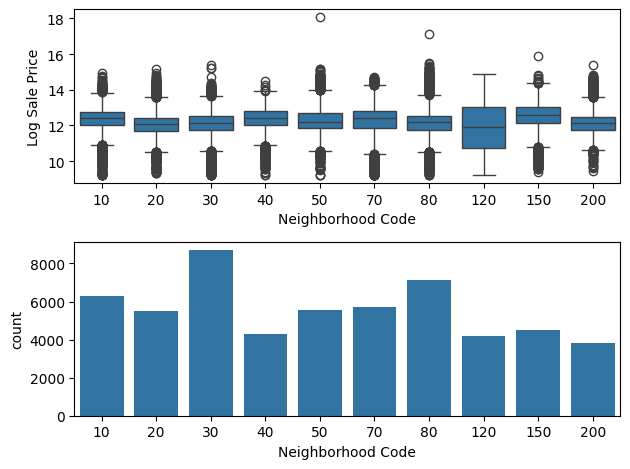

In [302]:
plot_categorical_feature(top_10_neighborhoods, "Log Sale Price", "Neighborhood Code")

## Additional Functions for Use in predictive_modeling.ipynb

In [303]:
def log_transform(data, feature):
    ''' 
    Function that applies the log transformation to a certain feature in the dataset
    Parameters:
        data -- dataset to grab from; DataFrame
        feature -- desired feature; str
    Returns:
        DataFrame with added log-transformed column
    '''
    data["Log " + feature] = np.log(data[feature])
    return data

def select_columns(data, *columns):
    '''Function that returns only specified columns from the DataFrame'''
    return data.loc[:, columns]